## Forecasting with GRUs

The data is about the monthly milk production in pounds per cow. 

https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line

### Import the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Read the data

In [2]:
milk = pd.read_csv('monthly-milk-production.csv',index_col='Month')

### Let us see the shape of the dataset

In [3]:
milk.shape

(168, 1)

In [4]:
print("There are " + str(milk.shape[0]) + " months in the dataset")

There are 168 months in the dataset


### Check out the top of the dataset

In [5]:
milk.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


In [6]:
print("The dataset begins on " + str(milk.index[0]))

The dataset begins on 1962-01-01 01:00:00


In [7]:
print("The dataset ends on " + str(milk.index[-1]))

The dataset ends on 1975-12-01 01:00:00


### Currently our index are in a string format

In [8]:
type(milk.index[0])

str

### Convert the index into a datetime format

In [9]:
milk.index = pd.to_datetime(milk.index)

### Index is not is datetime

In [10]:
type(milk.index[0])

pandas._libs.tslib.Timestamp

In [11]:
print("The dataset spans " + str(milk.index[-1].year - milk.index[0].year) + " years of monthly data")

The dataset spans 13 years of monthly data


### Let us now plot the timeseries

As we can see from the plot below, the data has very strong seasonality and is upwards trending.

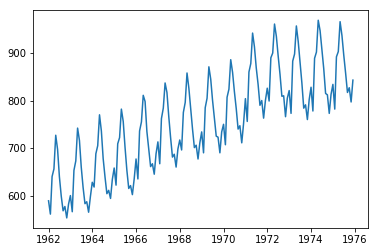

In [12]:
plt.plot(milk)

### Train Test Split
We are going to use the first 12 years of data (1962-1974) as the training and the last year (1975) as the test set.

### Get the index of the rows from 1962 to 1974

In [13]:
training_index = milk.index<"1975-1-1"

### Subset the dataset using said index

In [14]:
train = milk[training_index]
test_set = milk[~training_index]

### Train Data

In [15]:
train.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


In [16]:
train.tail()

,Milk Production
Month,
1974-08-01 01:00:00,867.0
1974-09-01 01:00:00,815.0
1974-10-01 01:00:00,812.0
1974-11-01 01:00:00,773.0
1974-12-01 01:00:00,813.0


### Testing

In [17]:
test_set

,Milk Production
Month,
1975-01-01 01:00:00,834.0
1975-02-01 01:00:00,782.0
1975-03-01 01:00:00,892.0
1975-04-01 01:00:00,903.0
1975-05-01 01:00:00,966.0
1975-06-01 01:00:00,937.0
1975-07-01 01:00:00,896.0
1975-08-01 01:00:00,858.0
1975-09-01 01:00:00,817.0


### Scale the Data

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test_set)

### Batch Function

We will need a batch function that will feed our data in batches since we are using tf

In [19]:
def next_batch(training_data,batch_size,steps):
    rand_start = np.random.randint(0,len(training_data)-steps) 
    y_batch = np.array(training_data[rand_start:rand_start+steps+1]).reshape(1,steps+1)
    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 

## Modeling - Tensorflow

In [20]:
import tensorflow as tf

### Hyperparameters

In [21]:
num_inputs = 1
num_time_steps = 12
num_neurons = 20
num_outputs = 1
learning_rate = 0.01
num_train_iterations = 4000
batch_size = 1

### Placeholders

In [22]:
X = tf.placeholder(tf.float32,[None,num_time_steps,num_inputs])
y = tf.placeholder(tf.float32,[None,num_time_steps,num_outputs])

### Layers

In [23]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
        tf.contrib.rnn.GRUCell(num_units=num_neurons, activation=tf.nn.tanh),
    output_size=num_outputs)

### Pass layers into into dynamic_rnn with the placeholder X. dynamic_rnn performs the dynamic unrolling of inputs.

In [24]:
outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

### Loss function (MSE)

In [25]:
loss = tf.reduce_mean(tf.square(outputs - y))

### Optimizer - Adam

In [26]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

### Apply optimizer to the Loss function

In [27]:
train = optimizer.minimize(loss)

### Initialize the global variables

In [28]:
init = tf.global_variables_initializer()

### Create an instance of Saver

In [29]:
saver = tf.train.Saver()

### Training the model

In [30]:
train_mse = []
with tf.Session() as sess:
    
    sess.run(init)
    for iteration in range(num_train_iterations):
        X_batch,y_batch = next_batch(train_scaled,batch_size,num_time_steps)
        sess.run(train,feed_dict = {X:X_batch,y:y_batch})
        
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
            print(iteration,'\tMSE',mse)
            train_mse.append(mse)

    saver.save(sess, "./ex_time_series_model")

0 	MSE 0.0321766
100 	MSE 0.00707949
200 	MSE 0.0101531
300 	MSE 0.00737771
400 	MSE 0.00904084
500 	MSE 0.00774632
600 	MSE 0.00400269
700 	MSE 0.0082671
800 	MSE 0.0082179
900 	MSE 0.00461551
1000 	MSE 0.00365135
1100 	MSE 0.0108288
1200 	MSE 0.00704118
1300 	MSE 0.00417121
1400 	MSE 0.0036004
1500 	MSE 0.005986
1600 	MSE 0.00773081
1700 	MSE 0.00364874
1800 	MSE 0.00439247
1900 	MSE 0.00246461
2000 	MSE 0.00410084
2100 	MSE 0.00265845
2200 	MSE 0.0127505
2300 	MSE 0.00755016
2400 	MSE 0.00402603
2500 	MSE 0.00335799
2600 	MSE 0.00386485
2700 	MSE 0.00328433
2800 	MSE 0.000877797
2900 	MSE 0.00374408
3000 	MSE 0.0041884
3100 	MSE 0.00439126
3200 	MSE 0.00250876
3300 	MSE 0.00983151
3400 	MSE 0.00227857
3500 	MSE 0.00358842
3600 	MSE 0.00250669
3700 	MSE 0.00625589
3800 	MSE 0.00518205
3900 	MSE 0.00392792


### Plotting the MSE

As we can see in the plot below our model learned very quickly and has reached optimality.

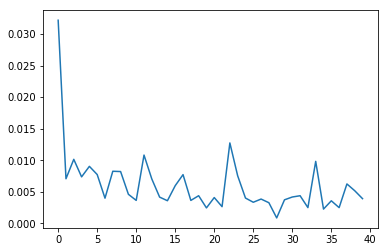

In [31]:
plt.plot(train_mse)

### Forecasting the next year

 Applying the model to the test set

In [32]:
with tf.Session() as sess:
    
    saver.restore(sess, "./ex_time_series_model") 
    
    train_seed = list(train_scaled[-12:])
    for iteration in range(12):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1,num_time_steps,1)
        
        y_pred = sess.run(outputs,feed_dict = {X:X_batch})
        
        train_seed.append(y_pred[0,-1,0])

INFO:tensorflow:Restoring parameters from ./ex_time_series_model


### Show results of the predictions

In [33]:
train_seed

[array([ 0.66105769]),
 array([ 0.54086538]),
 array([ 0.80769231]),
 array([ 0.83894231]),
 array([ 1.]),
 array([ 0.94711538]),
 array([ 0.85336538]),
 array([ 0.75480769]),
 array([ 0.62980769]),
 array([ 0.62259615]),
 array([ 0.52884615]),
 array([ 0.625]),
 0.67903376,
 0.56426293,
 0.8215059,
 0.83466578,
 0.96549642,
 0.88165432,
 0.81001145,
 0.72215337,
 0.65402013,
 0.62548971,
 0.58656132,
 0.66724408]

### Grab the portion of the results that are the generated values and apply inverse_transform on them to turn them back into milk production value units (lbs per cow). Also reshape the results to be (12,1) so we can easily add them to the test_set dataframe.

In [34]:
np.array(train_seed[12:]).reshape(12,1)

array([[ 0.67903376],
       [ 0.56426293],
       [ 0.8215059 ],
       [ 0.83466578],
       [ 0.96549642],
       [ 0.88165432],
       [ 0.81001145],
       [ 0.72215337],
       [ 0.65402013],
       [ 0.62548971],
       [ 0.58656132],
       [ 0.66724408]], dtype=float32)

In [35]:
results = scaler.inverse_transform(np.array(train_seed[12:]).reshape(12,1))

### Add new column "Generated" so that we can compare the forecast with the actuals

In [36]:
test_set['Generated'] = results

C:\Users\nickj\AppData\Local\Continuum\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [37]:
test_set

,Milk Production,Generated
Month,,
1975-01-01 01:00:00,834.0,835.478027
1975-02-01 01:00:00,782.0,787.733398
1975-03-01 01:00:00,892.0,894.746460
1975-04-01 01:00:00,903.0,900.220947
1975-05-01 01:00:00,966.0,954.646545
1975-06-01 01:00:00,937.0,919.768127
1975-07-01 01:00:00,896.0,889.964722
1975-08-01 01:00:00,858.0,853.415771
1975-09-01 01:00:00,817.0,825.072388


### Plot the comparison

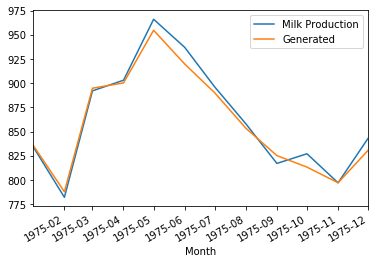

In [38]:
test_set.plot()

# Less than 1% MAPE

In [39]:
print("Our MAPE for the year 1975 is: " + str(np.mean(abs(test_set['Milk Production']-test_set['Generated'])/test_set['Milk Production']) * 100) + "%")

Our MAPE for the year 1975 is: 0.8233195412454852%
